In [1]:
#Jack Baxter
#First Agent

environment loaded


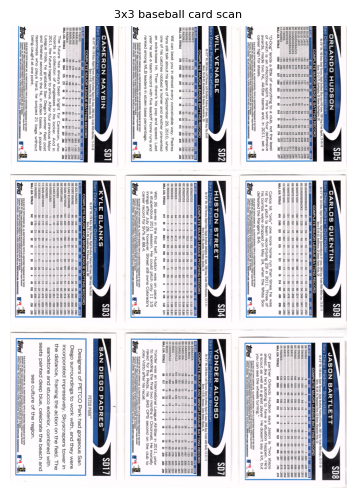

Full scan dimensions: 4784px wide × 6569px tall
Each card region will be: 1594px wide × 2189px tall


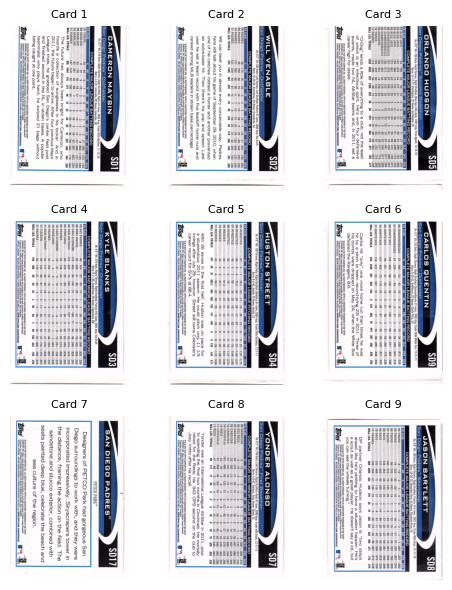

Extracting text from each card...
--Card 1 Text--
—_—

San Diego Padres” Outfielder
it: 6°3” Wt: 210 Bats: Right Throws: Right Drafted: Tigers #1-—June, 2005 Acq: Trade With Marlins, 11-13-10
Born: 4-4-87, Asheville, NC Home: Asheville, NG

‘YR CLUB. a ‘AB. "3B

07 TIGER 0 (1 265 473.1

“08 MARLINS 32 9 1 2 00 2 4 «8 563 1.105 .500
09 MARLINS 176 30 44 12 2 4 13 1 «17° 51 409 727 250
10 MARLINS 291 46 68 7 3 8 28 9 24 361 663 .234
11 PADRES 137 516 82 136 24 8 9 40 40 44 125 393 .716 .264
MAJ. LEA. TOTALS 305 1064 175 271 48 #13 22 85 59 91 297 386 704 255

The future has always been bright for Cameron, who
hoards a collection of sunglasses in his locker. And in
2011, the future began to arrive. After four previous Major
League trials, he grabbed San Diego's center field post
and finished second in the NL in stolen bases. A popular
teammate who plays hard, he swiped 21 bags without
being caught at one point.

@ & © 2012 THE TOPPS COMPANY, INC. ALL RIGHTS RESERVED, TOPPS IS A REGISTERED

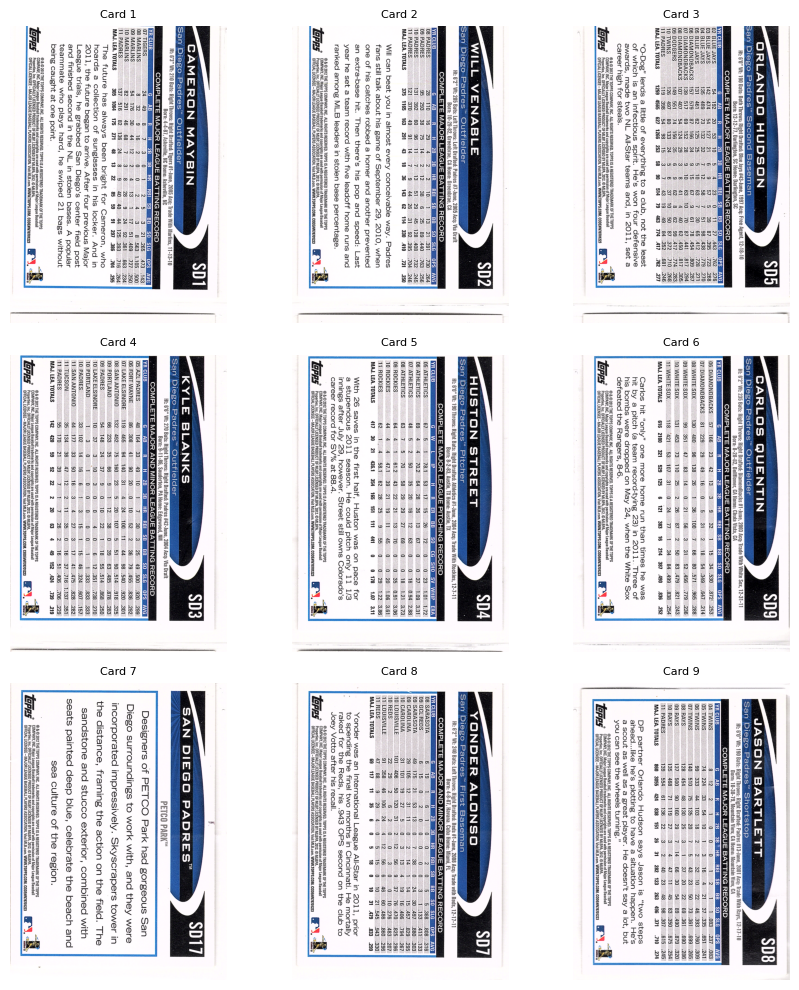

error: missing ), unterminated subpattern at position 8

In [ ]:
#import helper functions from utils.py
from utils import load_env, get_api_keys

#import libs for working with images
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
import base64
import json


#import opencv for image processing 
import cv2
import numpy as np

#import requests library 
import requests 

#import OCR library
import pytesseract
import re

#load the .env file from utils function
load_env()

#get path to scanned image
#put image in data folder 
#initialize path
image_path = "cardscans/baseball2.png"

#load image and display it
img = Image.open(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title('3x3 baseball card scan', fontsize=8)
plt.show()

#reload scan with opencv
img_cv = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

#get the dimensions of the image
height, width, _ = img_rgb.shape
print(f"Full scan dimensions: {width}px wide × {height}px tall")
print(f"Each card region will be: {width//3}px wide × {height//3}px tall")

#card dimenstion ratio
card_width = width // 3
card_height = height // 3
cropped_cards = []
for row in range(3):
    for col in range(3):
        x1 = col * card_width
        x2 = (col + 1) * card_width
        y1 = row * card_height
        y2 = (row + 1) * card_height
        
        card = img_rgb[y1:y2, x1:x2]
        cropped_cards.append(card)

# Display the 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(5, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(cropped_cards[i])
    ax.axis('off')
    ax.set_title(f"Card {i+1}", fontsize=8)
plt.tight_layout()
plt.show()

#use OCR to extract text from each card
#potentiall preproc here: 
def enhance_card(card_pil):
    return ImageOps.invert(ImageOps.grayscale(card_pil)).point(lambda x: 0 if x < 140 else 255)

#run OCR on each card
print('Extracting text from each card...')

#set list for text 
all_raw_texts = []

fig, axes = plt.subplots(3, 3, figsize=(9, 10))
for i, card_rgb in enumerate(cropped_cards):
    #convert to PIL image
    card_pil = Image.fromarray(card_rgb)
    #optional preproc here
    card_pil = enhance_card(card_pil)

    #run OCR
    text = pytesseract.image_to_string(card_pil)
    all_raw_texts.append(text)

    #display card 
    ax = axes.flat[i]
    ax.imshow(card_rgb)
    ax.axis('off')
    ax.set_title(f'Card {i+1}', fontsize=8)

    #print extracted text below
    print(f'--Card {i+1} Text--')
    print(text if text else '(no text detected)')
    print('\n')

plt.tight_layout()
plt.show()

#now to sort through metadata 

#first the sheet
sheet_metadata = {
    "sheet_id": "sheet_001",
    "scan_date": "2025-12-17",
    "scan_side": "back",
    "scanner_notes": "Clean 2012 Topps backs, excellent OCR",
    "collection_name": "My Collection",
    "binder_page": "Binder 1 - Page 1"
}

#now cards 
cards_data = []

for i, raw_text in enumerate(all_raw_texts):
    lines = [line.strip() for line in raw_text.split('\n') if line.strip()]

    #card gets sheet meta
    card = sheet_metadata.copy()
    #card spot on sheet
    card['card_position'] = f'Card {i+1}'
    #get all text for card
    card['raw_text'] = raw_text

    #get the player name (first line)
    if lines: 
        full_name_line = lines[0].replace('-', ' ').strip()
        full_name = full_name_line.strip().title()
        card['player_name'] = full_name

    #split name into first and last
    name_parts = full_name.split()
    if len(name_parts) >=2: 
        card['first_name'] = name_parts[0]
        card['last_name'] = ' '.join(name_parts[1:])
    elif len(name_parts) == 1:
        card['first_name'] = name_parts[0]
        card['last_name'] = ''
    else: 
        card['first_name'] = ''
        card['last_name'] = ''

    #team and position extraction
    if len(lines) >= 2: 
        team_pos_line = lines[1]
        if '"' in team_pos_line:
            parts = team_pos_line.split('"')
            if len(parts) >= 3:
                card['team'] = parts[0].strip().title()
                card['position'] = parts[2].strip().title()

    for line in lines: 
        if re.search(r'ht:|height:', line, re.I):
            ht_match = re.search(r'(\d\'\d+")',line)
            if ht_match: 
                card['height'] = ht_match.group(1)
        if re.search(r'wt:|weight:', line, re.I):
            wt_match = re.search(r'Wt:\s*(\d+)', line, re.I)
            if wt_match: 
                card['weight_lbs'] = int(wt_match.group(1))
        if re.search(r'Bats:', line, re.I):
            bats_match = re.search(r'Bats:\s*(Left|Right|Both|Switch)', line, re.I)
            if bats_match: 
                card['bats'] = bats_match.group(1).title()
        if re.search(r'Throws:', line, re.I):
            throws_match = re.search(r'Throws:\s*(Left|Right)', line, re.I)
            if throws_match: 
                card['throws'] = throws_match.group(1).title()
        if re.search(r'Born:', line, re.I):
            born_match = re.search(r'Born:\s*([\d-]+\s*,\d{4})', line, re.I)
            if born_match: 
                card['birth_date_raw'] = born_match.group(1)
        if re.search(r'Home:', line, re.I):
            home_match = re.search(r'Home:\s*(.+)', line, re.I)
            if home_match: 
                card['hometown'] = home_match.group(1).strip().title()
    
    #year, manufacturer, set (copyright)
    copyright_match = re.search(r'©\s*(\d{4})\s*THE TOPPS', raw_text, re.IGNORECASE)
    if copyright_match:
        card['year'] = copyright_match.group(1)
        card['manufacturer'] = 'Topps'
        f"{card.get('year', 'Unknown')} Topps" #can be refined 

    #card code 
    code_match = re.search(r'CODE[#:]?\s*([A-Z0-9-]+)', raw_text, re.IGNORECASE)
    if code_match: 
        card['card_code'] = code_match.group(1).strip()
    
    cards_data.append(card)

#save data
output_file = f"cardscans/{sheet_metadata['sheet_id']}_metadata.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(cards_data, f, indent=4, ensure_ascii=False)

print(f"✓ Parsed and split atomic data for {len(cards_data)} cards → {output_file}")
print("\nSample parsed card:")
print(json.dumps(cards_data[0], indent=2))